# Réplica del trabajo "Innate and Adaptive Immune Assessment at Admission to Predict Clinical Outcome in COVID-19 Patients" en python

En este estudio se evaluó la respuesta inmunitaria en pacientes con infección activa por SARS-CoV-2. Se estudiaron un total de 155 pacientes al ingreso en el Hospital Universitario Marqués de Valdecilla y se categorizaron según si requirieron de oxigenoterapia (severo) o no (leve).
    
El modelo predictivo incluyó la edada, ferritina, D-dimero, Número de linfocitos, C4, CD8+CD27-CD28-, y los monocitos no clásicos en un análisis de regresión logística.

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score

### Importación de datos

Importo en un dataframe la cohorte de datos

In [2]:
df_data = pd.read_csv('./data/data.csv', sep = ";")
df_data.index.name = 'idMuestra'
df_data.head(3)

,IDInm,NH,AntiN,AntiS,AntiM,age,gender,score,Line Timepoint,Timepoint,...,TH27p28n,TH27n28n,CTLDRn38n,CTLDRp38n,CTLDRn38p,CTLDRp38p,THDRn38n,THDRp38n,THDRn38p,THDRp38
idMuestra,,,,,,,,,,,,,,,,,,,,,
0,1407962,3084327,NaN,NaN,NaN,88,1,NaN,NaN,0.0,...,0.007514,0.037952,0.075808,0.064660,0.638796,0.220736,0.046994,0.024834,0.879776,0.048395
1,1407963,587116,NaN,NaN,NaN,46,0,NaN,NaN,0.0,...,0.001384,0.000951,0.057471,0.014049,0.826309,0.102171,0.035378,0.003979,0.938587,0.022057
2,1408025,764584,NaN,NaN,NaN,82,0,3.0,1.0,1.0,...,0.027458,0.085781,0.232804,0.037037,0.221164,0.508995,0.255428,0.018838,0.628991,0.096743


### Preparación de Datos

En el trabajo que vamos a replicar, se escogen los datos entre Abril y Octubre de 2020 y que hayan dado positivo en prueba PCR. Además descartamos los que no tienen score.

In [3]:
df_datos = df_data.copy()

# Descartamos los datos nulos o vacíos en el campo "score"
df_datos = df_datos[~df_datos[df_datos.columns[7]].isnull()]

# Descartamos los datos nulos o vacíos en el campo "fechaPCRpos" o los que son negativos "NEG"
df_datos = df_datos[~df_datos[df_datos.columns[19]].isnull()]
df_datos = df_datos[df_datos['fechaPCRpos'] != 'NEG']

# Escogemos los datos entre Abril y Octubre 2020
df_datos['fechaPCRpos'] = df_datos['fechaPCRpos'].astype('int64')
fechas = pd.to_datetime(df_datos['fechaPCRpos'], unit='d', origin='1899-12-30')
df_datos['FechaPCR'] = fechas
df_datos = df_datos[df_datos['FechaPCR'] < '2021-01-01']

Escojo las variables que quiero utilizar y las meto en otro dataframe

In [4]:
df_datos = df_datos[['score','age','ferritina','DimD','LINF ABS','C4','MoNOclasicos','TH27n28n']]
df_datos.shape

(155, 8)

Compruebo el número de nulos (NaN) de cada variable

In [5]:
df_datos.isnull().sum()

score            0
age              0
ferritina        6
DimD             5
LINF ABS         1
C4               3
MoNOclasicos    29
TH27n28n        16
dtype: int64

<AxesSubplot:ylabel='idMuestra'>

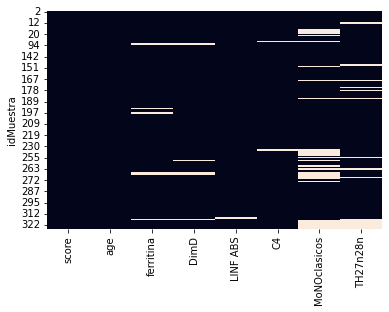

In [6]:
# Identificamos los valores NaN visualmente
sns.heatmap(df_datos.isnull(), cbar=False)

Convierto la multivariable score en 2 variables: 0 Leve y 1 Moderado/Severo

In [7]:
df_datos['score'] = np.where(df_datos['score'] > 1, 1, 0)

print("Número de observaciones por clase")
print(df_datos['score'].value_counts())
print("")

print("Porcentaje de observaciones por clase")
print(100 * df_datos['score'].value_counts(normalize=True))

Número de observaciones por clase
1    83
0    72
Name: score, dtype: int64

Porcentaje de observaciones por clase
1    53.548387
0    46.451613
Name: score, dtype: float64


Estos valores concuerdan con los utilizados en el trabajo original.

### Clasificación de datos

Creo los dataframes de entrenamiento (X) y de test (y)

In [8]:
X = df_datos.drop(columns = 'score').to_numpy()
y = df_datos['score'].to_numpy()

In [9]:
def evalua(X, y, clasificador, repeticiones, folds):
    '''
    Función de ejemplo que evalua roc_auc_score siguiendo un esquema
    de repeticiones y número de folds indicado.
    
    '''
    
    # se hacen 'repeticiones' validaciones cruzadas
    rocs = []
    
    # se hace el proceso 'repeticiones' veces
    for i in range(repeticiones):
        
        # se usa StratifiedKFold varias veces, cada vez con una semilla distinta
        skf = StratifiedKFold(n_splits = folds, random_state = i, shuffle = True)
        
        
        for train_index, test_index in skf.split(X, y):
            
            # se crean múltiples versiones de los conjuntos de entrenamiento y test
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # entrenamos y evaluamos el clasificador
            clasificador.fit(X_train, y_train)
            y_pred = clasificador.predict_proba(X_test)
            ### podría guardar las predicciones para más adelante si quisiera
            
            roc = roc_auc_score(y_test, y_pred[:,1])
            rocs.append(roc)
            
    # devolvemos la media de las repeticiones y folds
    return np.array(rocs).mean() * 100

### Regresión Logística con imputación

Creo varios pipelines para poder imputar a los valores NaN

Media

In [10]:
pipe1 = Pipeline([('ImputaMedia', SimpleImputer(strategy = "mean")), 
                 ('Logistic', LogisticRegression(solver = 'newton-cg', max_iter = 500))])
print(round(evalua(X, y, pipe1, 5, 3), 2), '%')
print(round(evalua(X, y, pipe1, 10, 3), 2), '%')

75.97 %
75.63 %


Mediana

In [11]:
pipe2 = Pipeline([('ImputaMedia', SimpleImputer(strategy = "median")), 
                 ('Logistic', LogisticRegression(solver = 'newton-cg', max_iter = 500))])
print(round(evalua(X, y, pipe2, 5, 3), 2), '%')
print(round(evalua(X, y, pipe2, 10, 3), 2), '%')

75.68 %
75.42 %


Más frecuentes

In [12]:
pipe3 = Pipeline([('ImputaMedia', SimpleImputer(strategy = "most_frequent")), 
                 ('Logistic', LogisticRegression(solver = 'newton-cg', max_iter = 500))])
print(round(evalua(X, y, pipe3, 5, 3), 2), '%')
print(round(evalua(X, y, pipe3, 10, 3), 2), '%')

75.52 %
75.31 %


Vecinos más cercanos

In [13]:
pipe4 = Pipeline([('ImputaKNN', KNNImputer(n_neighbors = 6)), 
                 ('Logistic', LogisticRegression(solver = 'newton-cg', max_iter = 500))])
print(round(evalua(X, y, pipe4, 5, 3), 2), '%')
print(round(evalua(X, y, pipe4, 10, 3), 2), '%')

75.85 %
75.57 %


Finalmente, observamos que el mejor resultado se da con la imputación de la media con 5 repeticiones y 3 folds

In [16]:
print('El mejor resultado es:', round(evalua(X, y, pipe1, 5, 3), 0), '%')

El mejor resultado es: 76.0 %
